# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid", {'axes.grid' : False})
# sns.set_style("whitegrid")

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# conda install -c conda-forge xgboost
# from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

# Supervised-Classifier-metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# Supervised-cross_validate-GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Import Data

In [2]:
df = pd.read_csv("Data/cleaned_train.csv")
df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,3392,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,26.822620,265.0,No,49.574949,24.785217,High_spent_Small_value_payments,312.494089,Good
1,3392,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,31.944960,266.0,No,49.574949,24.785217,Low_spent_Large_value_payments,284.629162,Good
2,3392,3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,28.609352,267.0,No,49.574949,24.785217,Low_spent_Medium_value_payments,331.209863,Good
3,3392,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,31.377862,268.0,No,49.574949,24.785217,Low_spent_Small_value_payments,223.451310,Good
4,3392,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,24.797347,269.0,No,49.574949,24.785217,High_spent_Medium_value_payments,341.489231,Good


# Final EDA

In [3]:
df.drop(columns=["Customer_ID", "Month"], inplace=True)

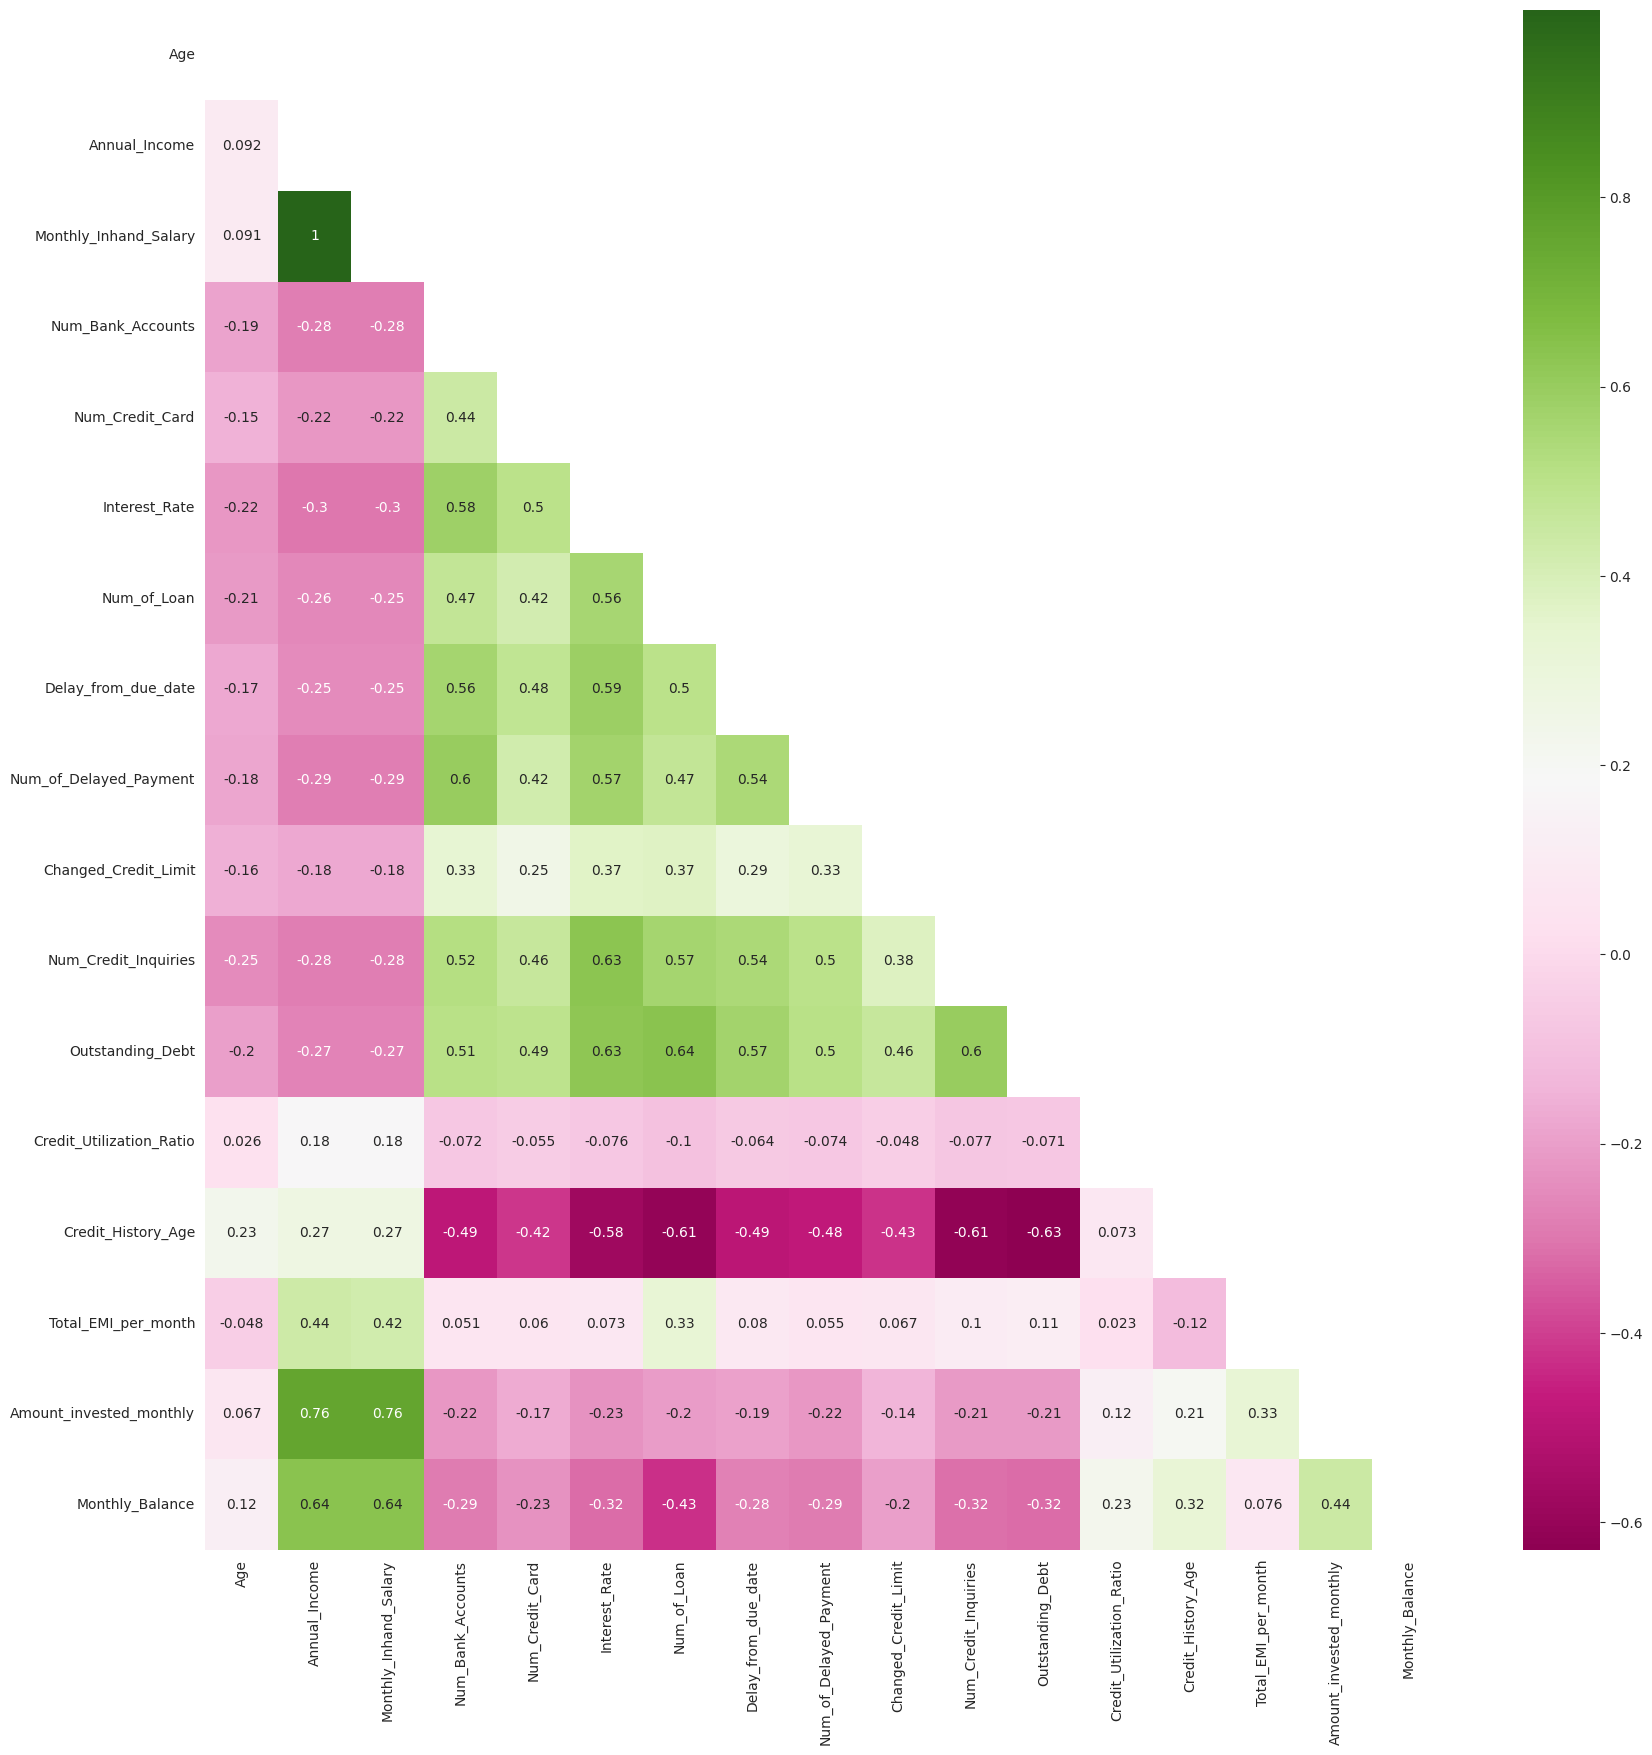

In [4]:
# Correlation between Numerical features
plt.figure(figsize=(20, 20))
sns.heatmap(df.select_dtypes(include = "number").corr(), 
            mask=np.triu(np.ones_like(df.select_dtypes(include = "number").corr(), dtype=bool)), 
            annot=True, cmap="PiYG")
plt.show()

# Train-Test Split

In [5]:
# Monthly in hand salary and anual income highly correlated
X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 22)
(70000,)
(30000, 22)
(30000,)


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# should be used to encode target values, i.e. y, and not the input X.

In [9]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Converting categorical variables to numbers (one-hot encoding)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class GetDummies(BaseEstimator, TransformerMixin): 
    def __init__(self, data_sep=',', col_name_sep='_'):
        self.data_sep     = data_sep
        self.col_name_sep = col_name_sep
        
    def fit(self, X, y  = None): 
        object_cols       = X.select_dtypes(include="object").columns
        self.dummy_cols   = [col for col in object_cols if X[col].str.contains(self.data_sep, regex=True).any()]
        self.dummy_prefix = [''.join(map(lambda x: x[0], col.split(self.col_name_sep)))  if self.col_name_sep in col else col[:2] for col in self.dummy_cols]
        
        for col, pre in zip(self.dummy_cols, self.dummy_prefix):
            dummy_X = X.join(X[col].str.get_dummies(sep=self.data_sep).add_prefix(pre+self.col_name_sep))            
            
        dummy_X.drop(columns = self.dummy_cols, inplace=True)
        self.columns = dummy_X.columns
        return self
    
    def transform(self, X, y = None):
        for col, pre in zip(self.dummy_cols, self.dummy_prefix):
            X_transformed = X.join(X[col].str.get_dummies(sep=self.data_sep).add_prefix(pre+self.col_name_sep))   

        X_transformed = X_transformed.reindex(columns=self.columns, fill_value=0)          
        return X_transformed
        
    # to get feature names    
    def get_feature_names_out(self, input_features=None):
        return self.columns.tolist()

The above function is for the column in which the categorical variables are seperated by comma or some seperator, in our case it is just one column "Type_of_loan".
Note : Now the column "Type of loan" has been dropped and instead we have one hot vectors for its place.

In [11]:
dummy = GetDummies()
X_train_dummy = dummy.fit_transform(X_train)
X_test_dummy   = dummy.transform(X_test)

In [12]:
X_train_dummy = X_train_dummy.reset_index(drop=True)
X_test_dummy = X_test_dummy.reset_index(drop=True)
# resetting index so that in future we can work with indexes 

* Apart from "Type_of_Loan" other categorical varaible needs to be converted into numbers.
* Assuming the features are Nominal (data represents categories without any inherent order or hierarchy.)
One-hot encoding is commonly used for nominal data.

In [13]:
from sklearn.preprocessing import OneHotEncoder
cat = X_train_dummy.select_dtypes(include="object").columns.tolist()   
print('Features which requires OneHotEncoder:', cat)

Features which requires OneHotEncoder: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']


In [14]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# sparse_output=False then the output of fit_transform will be a numpy array which can be easily converted to dataframe

# sparse_output=True then the output of fit_transform will be a sparse matrix which cannot be easily converted to dataframe

# for example
# <38x4 sparse matrix of type '<class 'numpy.float64'>'
# 	with 38 stored elements in Compressed Sparse Row format>

In [15]:
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[cat]),columns=ohe.get_feature_names_out())
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat]),columns=ohe.get_feature_names_out())

In [16]:
X_train_ohe = X_train_cat.join(X_train_dummy.select_dtypes("number"))
X_test_ohe = X_test_cat.join(X_test_dummy.select_dtypes("number"))

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [18]:
X_train_scaled = sc.fit_transform(X_train_ohe)
X_test_scaled = sc.transform(X_test_ohe)

# Model Training

1. Random Forest Classifier


In [19]:
rfc = RandomForestClassifier(random_state = 1337)

In [20]:
rfc.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1337)

In [21]:
y_pred = rfc.predict(X_test_scaled)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      5322
           1       0.80      0.84      0.82      8805
           2       0.83      0.81      0.82     15873

    accuracy                           0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000



With Best Parameters (GridsearchCV)

In [23]:
rfc_best = RandomForestClassifier(random_state=1337)
param_grid = {
    "class_weight": ["balanced"], # [None, 'balanced', 'balanced_subsample']
    "n_estimators": np.linspace(100, 200, 2, dtype=int),
    "criterion"   : ["gini", "entropy"],
    "max_depth"   : np.arange(2, 3, 1), 
    "min_impurity_decrease": [0],
    "oob_score"   : [True],
}
grid_model_rfc = GridSearchCV(
    estimator=rfc_best,
    param_grid=param_grid,
    scoring = "accuracy",      
    error_score="raise",  
    n_jobs = -1,
    cv=5,
)

In [24]:
grid_model_rfc.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=1337), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([2]), 'min_impurity_decrease': [0],
                         'n_estimators': array([100, 200]),
                         'oob_score': [True]},
             scoring='accuracy')

In [25]:
# Get the best hyperparameters
best_paramsl_rfc = grid_model_rfc.best_params_

In [26]:
best_paramsl_rfc, grid_model_rfc.best_score_

({'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 2,
  'min_impurity_decrease': 0,
  'n_estimators': 100,
  'oob_score': True},
 0.6676857142857143)

In [27]:
y_pred = grid_model_rfc.predict(X_test_scaled)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.83      0.62      5322
           1       0.63      0.75      0.68      8805
           2       0.85      0.57      0.68     15873

    accuracy                           0.67     30000
   macro avg       0.66      0.71      0.66     30000
weighted avg       0.72      0.67      0.67     30000



2. Logistic Regression

In [32]:
lr = LogisticRegression(random_state=1337)

In [33]:
lr.fit(X_train_scaled,y_train)

/home/saurabh/Downloads/Projects/Credit score classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1337)

In [34]:
y_pred = lr.predict(X_test_scaled)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61      5322
           1       0.66      0.55      0.60      8805
           2       0.70      0.72      0.71     15873

    accuracy                           0.66     30000
   macro avg       0.64      0.65      0.64     30000
weighted avg       0.66      0.66      0.66     30000



With Best Parameters (GridsearchCV)

In [42]:
lr_best = LogisticRegression(random_state=1337)
param_grid = {
    # "penalty"     : ["l1", "l2"],
    "C"           : np.linspace(0.01, 1, 2).round(3),
    "class_weight": ["balanced"],
    # "solver"      : ["saga", "liblinear"]
}
grid_model_lr = GridSearchCV(
    estimator=lr_best,
    param_grid=param_grid,
    scoring = "accuracy",      
    error_score="raise",  
    n_jobs = -1,
    cv=5,
)

In [43]:
grid_model_lr.fit(X_train_scaled, y_train)

/home/saurabh/Downloads/Projects/Credit score classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/saurabh/Downloads/Projects/Credit score classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(random_state=1337), n_jobs=-1,
             param_grid={'C': array([0.01, 1.  ]),
                         'class_weight': ['balanced']},
             scoring='accuracy')

In [44]:
y_pred = lr.predict(X_test_scaled)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61      5322
           1       0.66      0.55      0.60      8805
           2       0.70      0.72      0.71     15873

    accuracy                           0.66     30000
   macro avg       0.64      0.65      0.64     30000
weighted avg       0.66      0.66      0.66     30000



# Saving model and other files for inference

In [46]:
pickle.dump(grid_model_rfc, open("models/grid_model_rfc.pkl", "wb"))
pickle.dump(grid_model_lr, open("models/grid_model_lr.pkl", "wb"))
pickle.dump(ohe, open("models/credit_score_multi_class_ohe_encoder.pkl", "wb"))
pickle.dump(le, open("models/credit_score_multi_class_le.pkl", "wb"))
pickle.dump(sc, open("models/credit_score_multi_class_sc.pkl", "wb"))
pickle.dump(dummy, open("models/credit_score_multi_class_get_dummy.pkl", "wb"))

sanity check

In [47]:
pickled_model = pickle.load(open("models/grid_model_rfc.pkl", "rb"))

In [48]:
y_pred = pickled_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.83      0.62      5322
           1       0.63      0.75      0.68      8805
           2       0.85      0.57      0.68     15873

    accuracy                           0.67     30000
   macro avg       0.66      0.71      0.66     30000
weighted avg       0.72      0.67      0.67     30000

